In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from matplotlib import cm
from tqdm import tqdm

from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.discriminative_models import MultinomialLogisticRegression
from counterfactuals.generative_models import MaskedAutoregressiveFlow

In [22]:
def plot_model_distribution(model, median_prob=None, disc_model=None):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 12)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-0.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid0 = model(xyinput, torch.zeros(40000, 1)).exp().reshape(200, 200)
        zgrid1 = model(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)

    zgrid0 = zgrid0.numpy()
    zgrid1 = zgrid1.numpy()

    _ = ax.contour(
        xgrid.numpy(),
        ygrid.numpy(),
        zgrid0,
        levels=10,
        cmap="Greys",
        linewidths=0.4,
        antialiased=True,
    )
    _ = ax.contour(
        xgrid.numpy(),
        ygrid.numpy(),
        zgrid1,
        levels=10,
        cmap="Oranges",
        linewidths=0.4,
        antialiased=True,
    )
    return ax

In [42]:
dataset = MoonsDataset(file_path="../data/moons.csv")
X_train, X_test, y_train, y_test = next(
    iter(dataset.get_cv_splits())
)  # yields splits one by one

disc_model = MultinomialLogisticRegression(dataset.X_train.shape[1], 2)
disc_model.load("../models/MoonsDataset/disc_model_0_MultinomialLogisticRegression.pt")

flow = MaskedAutoregressiveFlow(
    dataset.X_train.shape[1],
    hidden_features=4,
    num_blocks_per_layer=2,
    num_layers=5,
    context_features=1,
)
flow.load("../models/MoonsDataset/gen_model_0_MaskedAutoregressiveFlow.pt")
cf = PPCEF(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=MulticlassDiscLoss(),
    neptune_run=None,
)

In [18]:
median_prob = (
    flow.predict_log_prob(dataset.train_dataloader(batch_size=64, shuffle=False))
    .median()
    .item()
)

x_origin = torch.tensor([[-0.6, 0.65]], requires_grad=False)
x = torch.tensor([[-0.6, 0.65]], requires_grad=True)
context_origin = torch.Tensor([0])
context_target = torch.Tensor([1]).long()

optimizer = torch.optim.Adam([x], lr=0.005)
min_loss = np.inf
no_improve = 0

num_iterations = 2000
patience = 20
alpha = 10


p_hist = []

for i in tqdm(range(num_iterations)):
    optimizer.zero_grad()
    loss_components = cf.search_step(
        x, x_origin, context_origin, context_target, alpha=alpha, delta=median_prob
    )
    mean_loss = loss_components["loss"].mean()
    mean_loss.backward()
    optimizer.step()

    if mean_loss.item() < min_loss:
        min_loss = mean_loss.item()
    else:
        no_improve += 1
    if no_improve > patience:
        break

    if i % 150 == 0:
        p_hist.append(x.detach().numpy().copy())

p_hist.append(x.detach().numpy().copy())
p_hist = np.concatenate(p_hist)

 41%|████      | 822/2000 [00:01<00:02, 417.66it/s]


In [ ]:
flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
cf = PPCEF(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=torch.nn.BCELoss(),
    checkpoint_path="model.pt",
    neptune_run=None,
)

In [ ]:
train_dataloader = dataset.train_dataloader(batch_size=64, shuffle=True, noise_lvl=1e-5)
test_dataloader = dataset.test_dataloader(batch_size=64, shuffle=False)
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=200,
)

In [34]:
list(disc_model.parameters())

[Parameter containing:
 tensor([[-1.7852,  1.8039],
         [ 2.1693, -2.5909]], requires_grad=True),
 Parameter containing:
 tensor([0.5416, 0.7361], requires_grad=True)]

ValueError: can only convert an array of size 1 to a Python scalar

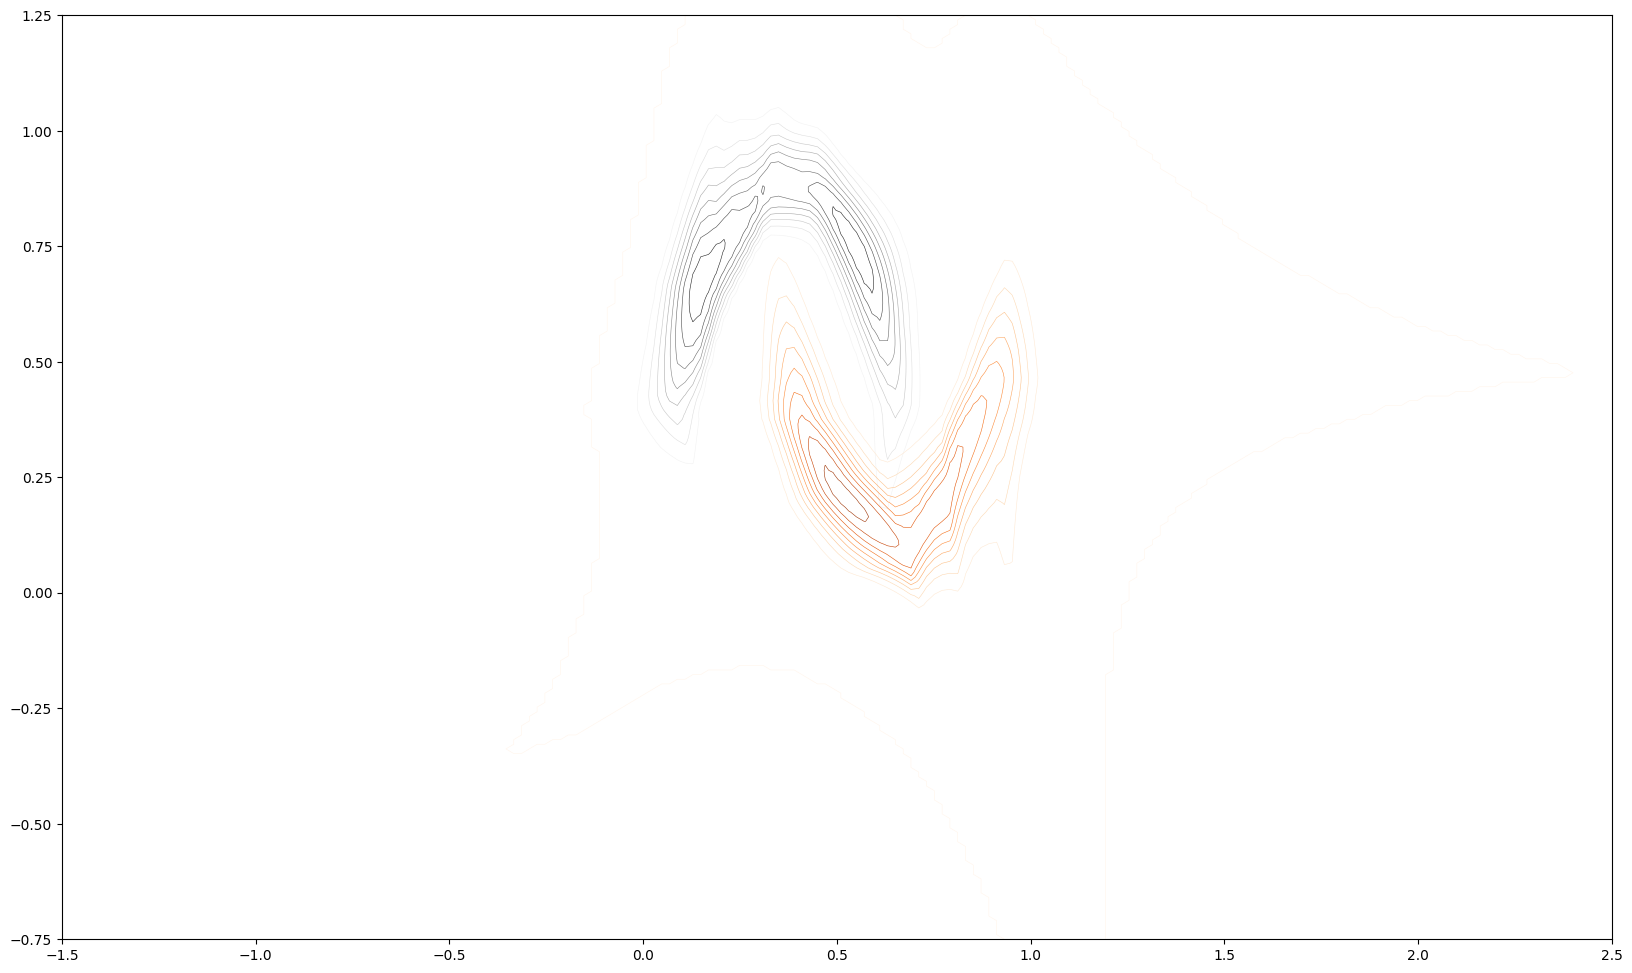

In [33]:
## Distribution Plot
ax = plot_model_distribution(flow, median_prob, disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b / w2
m = -w1 / w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m * xd + c
plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
plt.axis("off")

## Arrows
for i in range(p_hist.shape[0] - 1):
    ax.arrow(
        p_hist[i, 0],
        p_hist[i, 1],
        p_hist[i + 1, 0] - p_hist[i, 0],
        p_hist[i + 1, 1] - p_hist[i, 1],
        width=0.015,
        lw=0.001,
        length_includes_head=True,
        alpha=0.5,
        color="k",
    )

ax.scatter(p_hist[0:1, 0], p_hist[0:1, 1], c="k", s=100, alpha=0.8)
ax.scatter(p_hist[1:-1, 0], p_hist[1:-1, 1], c="orange", s=100, alpha=0.8)
ax.scatter(p_hist[-1:, 0], p_hist[-1:, 1], c="#DC143C", s=100, alpha=0.8)
_ = ax.axis("off")

## Save Figure
plt.tight_layout()
plt.savefig("moons.pdf")

In [38]:
import pandas as pd


X_cf = pd.read_csv(
    "../models/MoonsDataset/ppcef/counterfactuals_MultinomialLogisticRegression_0.csv"
).values

/var/folders/zx/yxz7rcp937j5xxx6svjlpc180000gn/T/ipykernel_97329/932017171.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.get_cmap("tab10"), s=100, alpha=0.8)


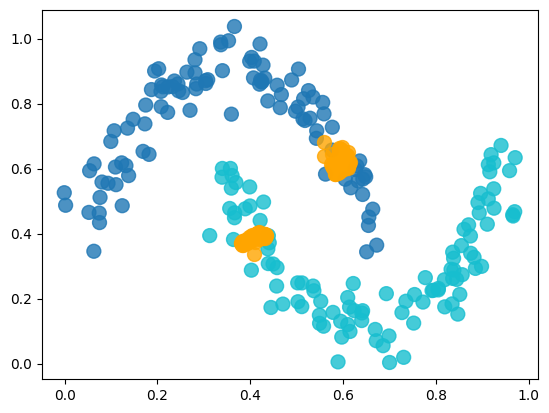

In [45]:
plt.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.get_cmap("tab10"), s=100, alpha=0.8
)
plt.scatter(X_cf[:, 0], X_cf[:, 1], c="orange", s=100, alpha=0.8)
plt.show()